In [89]:
import glob
import math
import os
import random
import json
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from datetime import datetime as dt
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, LearningRateScheduler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from losses import categorical_focal_loss

from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
print("TF Version:", tf.__version__)

TF Version: 1.15.0


In [119]:
train_dir = '/Users/aravindagayan/Documents/Projects/DataSets/Cat_Dog_data/train'
test_dir = '/Users/aravindagayan/Documents/Projects/DataSets/Cat_Dog_data/test'

#model_json = 
#model_weight = 

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

### Check Images

In [75]:
import pygal 
from IPython.display import display, HTML

#Create function to display interactive plotting
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))
    
#Compare class distribution
line_chart = pygal.Bar(height=300)
line_chart.title = 'Class Distribution'
for o in os.listdir(train_dir):
    if not o.startswith('.'):
        line_chart.add(o, len(os.listdir(os.path.join(train_dir, o))))
galplot(line_chart)

Text(0.5, 1.0, 'dog')

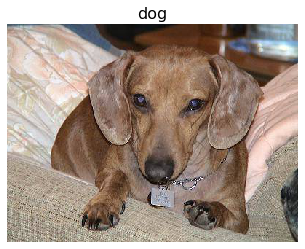

In [156]:
file_list = glob.glob(os.path.join(train_dir,'*','*'))
img_path = random.choice(file_list)
img = load_img(img_path)
car_class = img_path.split("/")[-2]
plt.imshow(img)
plt.axis("off")
plt.title(car_class, fontsize=16)

### Checking for corrupted Files

In [106]:
from os import listdir
from PIL import Image

file_list = [i for i in glob.glob(os.path.join(train_dir,'*','*')) if i.split('/')[-1].split('.')[-1].lower() in ['jpg','png','jpeg']]
   
for filename in file_list:
    try:
        img = Image.open(filename) # open the image file
        img.verify() # verify that it is, in fact an image
    except (IOError, SyntaxError) as e:
        print('Bad file: ', filename) # print out the names of corrupt files
print('Checked '+ str(len(file_list))+' Images')

Checked 22500 Images


### Seperate train, val, test set

In [179]:
import math
import re
import sys
import shutil

#Train and Test Set Variables
orginal_data_path ='/Users/aravindagayan/Documents/Projects/DataSets/TR'

train_val_test_ratio = (.8, .1, .1) #  Data Split
test_folder = '/Users/aravindagayan/Documents/Projects/DataSets/Cat_Dog_data/test/'
train_folder = '/Users/aravindagayan/Documents/Projects/DataSets/Cat_Dog_data/train/'
val_folder = '/Users/aravindagayan/Documents/Projects/DataSets/Cat_Dog_data/val/'

file_names = os.listdir(orginal_data_path)
file_names = [i for i in file_names if not i.startswith('.')]

#Remove Existing Folders if they exist
for folder in [test_folder, train_folder, val_folder]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)
        
#Remake Category Folders in both Train and Test Folders
for category in file_names:
    os.makedirs(test_folder + category)
    os.makedirs(train_folder + category)
    os.makedirs(val_folder + category)

#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(file_names):
    file_list = os.listdir(orginal_data_path + '/' + category)
    
    train_ratio = math.floor(len(file_list) * train_val_test_ratio[0])
    val_ratio = math.floor(len(file_list) * train_val_test_ratio[1])
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    test_list = file_list[train_ratio + val_ratio:]
    
    for i, file in enumerate(train_list):
        shutil.copy(orginal_data_path + '/' + category + '/' + file, train_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy(orginal_data_path + '/' + category + '/' + file, val_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    for i, file in enumerate(test_list):
        shutil.copy(orginal_data_path + '/' + category + '/' + file, test_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s test images to category folder %s' % (len(test_list), category))
    sys.stdout.write('\n')
print("Done.")  

Moving 9000 train images to category folder cat
Moving 1125 validation images to category folder cat
Moving 1125 test images to category folder cat
Moving 9000 train images to category folder dog
Moving 1125 validation images to category folder dog
Moving 1125 test images to category folder dog
Done.


### Image Iterator

In [120]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)

train_flow = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    subset='training',
    shuffle=True)

val_flow = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    subset='validation',
    shuffle=False)

Found 20250 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


### Check Train set images

In [142]:
CLASS_NAMES = [k for k,v in train_flow.class_indices.items()]

In [145]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n].argmax()].title())
        plt.axis('off')

In [180]:
image_batch, label_batch = next(train_flow)
show_batch(image_batch, label_batch)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aravindagayan/Documents/Projects/DataSets/Cat_Dog_data/train/dog/dog.9016.jpg'

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')